In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import sklearn
import category_encoders as ce
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot
%matplotlib inline

In [2]:
# Read in the data
df = pd.read_csv('https://raw.githubusercontent.com/reidharris01/Lambda-Build-Week-Projects/master/wish_sales_data.csv')

# Define a function that will clean any dataframe of this format.

def wrangle(X):
  # Drop columns with data we don't want to use
  X.drop(['title_orig', 'currency_buyer', 'theme', 'crawl_month',
           'countries_shipped_to','merchant_name',
          'merchant_info_subtitle','merchant_id','merchant_profile_picture',
          'product_url','product_picture','product_id','title',
           'merchant_title','urgency_text','shipping_option_name',
          'rating_one_count','rating_two_count','rating_three_count',
          'rating_four_count','rating_five_count','shipping_is_express',
          'price'],
          axis=1,
          inplace=True)
  # We want 'has_urgency_banner' NaNs to be zeros
  X.has_urgency_banner.replace({np.nan:0, 1.0:1},inplace=True)
  # Remove messy string column 'tags'
  X.drop(['tags'], axis=1, inplace=True)
  # Make categories for units sold, as they're only in certain values now
  for i in X.index:
    if X.units_sold.iloc[i] <= 100:
      X.units_sold.iloc[i] = 'low'
    elif (100 < X.units_sold.iloc[i]) & (X.units_sold.iloc[i] <= 1000):
      X.units_sold.iloc[i] = 'medium'
    else:
      X.units_sold.iloc[i] = 'high'

  # Deal with sizes:

  # Replace NaN's with 'none'
  X.product_variation_size_id.replace({np.nan:'none'},inplace=True)
  # Replace product_variation_size_id values with values from 3XS to 6XL, as
  # well as 'other' and 'shoes'
  X.product_variation_size_id.replace({
    'Size-XS':'XS', 'M.':'M', 'S.':'S', 's':'S', 'choose a size':'none',
    'XS.':'XS', '32/L':'L', 'XS.':'XS', 'Suit-S':'none', 'EU 35':'other',
    '4':'other', 'Size S.':'S', '1m by 3m':'other',
    'Size S':'S', '26(Waist 72cm 28inch)':'other', 'Size XXS':'2XS',
    '29':'other', 'Women Size 36':'other', 'US 6.5 (EU 37)':'other',
    'SIZE XS':'XS', '1pc':'none', '100 cm':'other', 'One Size':'onesize',
    'SIZE-4XL':'4XL', '1':'none', 'S/M(child)':'2XS', '2pcs':'other',
    'S..':'S', '30 cm':'other', 'XXS':'2XS', 'XXL':'2XL', 'XXXXXL':'5XL',
    'XXXL':'3XL', 'XXXS':'3XS', 'XXXXL':'4XL', '33':'other', 'Size M':'M',
    '100 x 100cm(39.3 x 39.3inch)':'other','100pcs':'none',
    'SIZE XXS':'2XS','Base & Top & Matte Top Coat':'other','size S':'S',
    '35':'other','34':'other','SIZE-XXS':'2XS','S(bust 88cm)':'S',
    'S (waist58-62cm)':'S','S(Pink & Black)':'S','20pcs':'none','US-S':'S',
    'Size -XXS':'2XS','X   L':'XL','25':'other','SizeL':'L','Size-S':'S',
    'Round':'other','Pack of 1':'other','S Diameter 30cm':'S',
    'AU plug Low quality':'other','5PAIRS':'other','25-S':'S','Size/S':'S',
    'S Pink':'S','Size-5XL':'5XL','daughter 24M':'other','2':'other',
    'Baby Float Boat':'other','10 ml':'other','60':'other',
    'US5.5-EU35':'other','10pcs':'other','17':'other','Size-XXS':'2XS',
    'Women Size 37':'other','3 layered anklet':'other','4-5 Years':'other',
    'Size4XL':'4XL','first  generation':'other','80 X 200 CM':'other',
    'EU39(US8)':'other','L.':'L','Base Coat':'other','36':'other',
    '04-3XL':'3XL','pants-S':'S','Floating Chair for Kid':'other',
    '20PCS-10PAIRS':'other','B':'other','Size--S':'S','5':'other',
    '1 PC - XL':'XL','H01':'other','40 cm':'other','SIZE S':'S',
    '1 pc.':'other','White':'other','Size-L':'L'},
    inplace=True)
  # Group together really large and really small items as well as 'other'
  X.product_variation_size_id.replace({
      '3XL':'3XL+','4XL':'3XL+','3XS':'2XS-','5XL':'3XL+','none':'other',
      'onesize':'other','6XL':'3XL+','2XS':'2XS-'},inplace=True)
  
  # Deal with colors:

  # Replace NaN's in product_color with 'other'
  X.product_color.replace({np.nan:'other'},inplace=True)
  # Reduce cardinality by manipulating strings:
  # Replace a few of the more difficult ones first
  X.product_color.replace({
      'blackwhite':'multicolor','orange-red':'orange','rosegold':'pink',
      'leopardprint':'multicolor','coffee':'brown','rose':'red',
      'leopard':'multicolor','camouflage':'multicolor','apricot':'orange',
      'navy':'blue','camel':'brown','burgundy':'purple','wine':'purple',
      'army':'green','rainbow':'multicolor','gold':'other','jasper':'red',
      'silver':'other','nude':'other','claret':'pink','ivory':'white',
      'star':'other','violet':'purple','tan':'other'},inplace=True)
  # If string has ampersand, or 'floral' in it, replace it with 'multicolor'
  for i in X.index:
    if ('&' in X.product_color.iloc[i]) | ('floral' in X.product_color.iloc[i]):
      X.product_color.iloc[i] = 'multicolor'
  # Remove instances of the word 'light'
    elif 'light' in X.product_color.iloc[i]:
      X.product_color.iloc[i] = X.product_color.iloc[i].replace('light','')
    else:
      pass
  # Make an exhaustive list of colors
  colors = ['red','orange','yellow','green','blue','purple','pink','brown',
          'gray','black','white','multicolor','khaki','biege','other']
  # Make all letters in each string lowercase
  for i in X.index:
    X.product_color.iloc[i] = X.product_color.iloc[i].lower()
  # Deal with the items using the British spelling of 'grey'
  X.product_color.replace({'grey':'gray','greysnakeskinprint':'gray'},
                          inplace=True)
  # If the string has 'blue' anywhere in it, then make it be just 'blue'
  # and the same for every color
  for i in X.index:
    for x in colors:
      if x in X.product_color.iloc[i]:
        X.product_color.iloc[i] = x
      else:
        pass

  # Deal with countries

  # Most are China, and all those that aren't China have small values. So, we'll
  # make a binary column indicating if it's Chinese and drop 'origin_country'
  X['from_CN'] = X['rating'] # Creates the new column
  for i in X.index:
    if X.origin_country.iloc[i] == 'CN':
      X.from_CN.iloc[i] = int(1)
    else:
      X.from_CN.iloc[i] = int(0)
  X.drop('origin_country',axis=1,inplace=True)

  # Remove sellers with fewer than 

  # Shuffle rows in case data is clumped by any certain feature
  X = shuffle(X).reset_index(drop=True)

  # Display cleaned DF head
  return X.head()

# Make copy of dataframe and clean it
clean = df.copy()
wrangle(clean)

,retail_price,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture,from_CN
0,7,high,0,4.14,2737,0,0,0,0,pink,S,50,3,50,1.0,68339,4.298746,0,1.0
1,31,high,0,4.09,2789,0,0,0,0,white,S,50,2,50,0.0,11596,4.280442,0,1.0
2,7,low,0,2.67,3,0,0,0,0,pink,S,46,2,50,1.0,1374,4.058952,0,1.0
3,14,medium,1,4.52,552,3,1,1,1,other,other,50,6,50,0.0,6033,4.254434,0,1.0
4,4,high,0,3.39,783,0,0,0,0,pink,S,7,1,50,0.0,32168,3.884544,0,1.0


In [3]:
# Rename columns to be shorter/easier to type/remember
clean.columns = ['price','sales','ad_boost','product_rating',
                 'product_rating_count','badges_count','badge_local_product',
                 'badge_product_quality',
                 'badge_fast_shipping','color','size','variation_inventory',
                 'shipping_price','total_inventory','has_urgency_banner',
                 'merchant_rating_count','merchant_rating','profile_pic',
                 'from_CN']
clean.head()

,price,sales,ad_boost,product_rating,product_rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,color,size,variation_inventory,shipping_price,total_inventory,has_urgency_banner,merchant_rating_count,merchant_rating,profile_pic,from_CN
0,14,low,0,3.76,54,0,0,0,0,white,M,50,4,50,1.0,568,4.128521,0,1.0
1,22,high,1,3.45,6135,0,0,0,0,green,XS,50,2,50,1.0,17752,3.899673,0,1.0
2,43,low,0,3.57,14,0,0,0,0,multicolor,XS,1,3,50,1.0,295,3.989831,0,1.0
3,8,high,1,4.03,579,0,0,0,0,black,M,50,2,50,0.0,23832,4.020435,0,1.0
4,3,low,1,3.10,20,0,0,0,0,yellow,S,1,1,50,1.0,14482,4.001588,0,1.0


In [4]:
# Turn badge_product_quality, badge_local_product, and badge_fast_shipping
# columns into one ordinally-encoded column

# Create a new column with a column of the target data type
clean['badges'] = clean.sales
for i in clean.index:
  if clean.badges_count.iloc[i] == 0:
    clean['badges'].iloc[i] = 'none'
  elif (clean.badge_local_product.iloc[i] == 1) & (clean.badge_fast_shipping.iloc[i] == 0) & (clean.badge_product_quality.iloc[i] == 0):
    clean['badges'].iloc[i] = 'local'
  elif (clean.badge_local_product.iloc[i] == 1) & (clean.badge_fast_shipping.iloc[i] == 0) & (clean.badge_product_quality.iloc[i] == 1):
    clean['badges'].iloc[i] = 'local & quality'
  elif (clean.badge_local_product.iloc[i]) == 1 & (clean.badge_fast_shipping.iloc[i] == 1) & (clean.badge_product_quality.iloc[i] == 0):
    clean['badges'].iloc[i] = 'local & fast'
  elif (clean.badge_local_product.iloc[i] == 1) & (clean.badge_fast_shipping.iloc[i] == 1) & (clean.badge_product_quality.iloc[i] == 1):
    clean['badges'].iloc[i] = 'local, fast, & quality'
  elif (clean.badge_local_product.iloc[i] == 0) & (clean.badge_fast_shipping.iloc[i] == 0) & (clean.badge_product_quality.iloc[i] == 1):
    clean['badges'].iloc[i] = 'quality'
  elif (clean.badge_local_product.iloc[i] == 0) & (clean.badge_fast_shipping.iloc[i] == 1) & (clean.badge_product_quality.iloc[i] == 0):
    clean['badges'].iloc[i] = 'fast'
  elif (clean.badge_local_product.iloc[i] == 0) & (clean.badge_fast_shipping.iloc[i] == 1) & (clean.badge_product_quality.iloc[i] == 1):
    clean['badges'].iloc[i] = 'fast & quality'
  else:
    pass

# Remove the one-hot encoded badge columns
clean.drop(['badge_local_product','badge_fast_shipping',
            'badge_product_quality','badges_count'], axis=1, inplace=True)

In [5]:
# Define a function to remove leaky features
def remove_leaky(X):
  X.drop(['product_rating_count',
          'merchant_rating_count',
          'variation_inventory',
          'total_inventory'],axis=1,inplace=True)
  return X.head()

# Apply the function
remove_leaky(clean)

,price,sales,ad_boost,product_rating,color,size,shipping_price,has_urgency_banner,merchant_rating,profile_pic,from_CN,badges
0,14,low,0,3.76,white,M,4,1.0,4.128521,0,1.0,none
1,22,high,1,3.45,green,XS,2,1.0,3.899673,0,1.0,none
2,43,low,0,3.57,multicolor,XS,3,1.0,3.989831,0,1.0,none
3,8,high,1,4.03,black,M,2,0.0,4.020435,0,1.0,none
4,3,low,1,3.10,yellow,S,1,1.0,4.001588,0,1.0,none


In [6]:
# Split it

# 70% training, 15% validation, 15% test
train_mask = (clean.index <= 0.7 * clean.shape[0])
val_mask = (0.7 * clean.shape[0] < clean.index) & (clean.index <= 0.85 * clean.shape[0])
test_mask = (0.85 * clean.shape[0] < clean.index)

train = clean[train_mask]
val = clean[val_mask]
test = clean[test_mask]

# Features from Targets
X_train, y_train = train.drop('sales', axis=1), train.sales
X_val, y_val = val.drop('sales', axis=1), val.sales
X_test, y_test = test.drop('sales', axis=1), test.sales

In [7]:
# Make sure train/val/test are split correctly
assert .69 < train.shape[0]/clean.shape[0] < .71
assert .14 < val.shape[0]/clean.shape[0] < .16
assert .14 < test.shape[0]/clean.shape[0] < .16

In [8]:
# Make sure splits didn't cause any NaNs to arise
assert X_train.isnull().sum().sum() == 0
assert X_val.isnull().sum().sum() == 0
assert X_test.isnull().sum().sum() == 0

In [33]:
y_train.value_counts()

low       443
high      374
medium    285
Name: sales, dtype: int64

# Baseline

In [9]:
baseline = y_train.value_counts()[0] / y_train.value_counts().sum()
print('Baseline Accuracy:', baseline)

Baseline Accuracy: 0.40199637023593465


# Model

In [10]:
X_train.head()

,price,ad_boost,product_rating,color,size,shipping_price,has_urgency_banner,merchant_rating,profile_pic,from_CN,badges
0,14,0,3.76,white,M,4,1.0,4.128521,0,1.0,none
1,22,1,3.45,green,XS,2,1.0,3.899673,0,1.0,none
2,43,0,3.57,multicolor,XS,3,1.0,3.989831,0,1.0,none
3,8,1,4.03,black,M,2,0.0,4.020435,0,1.0,none
4,3,1,3.10,yellow,S,1,1.0,4.001588,0,1.0,none


In [11]:
# Define and fit model
forest_clf = make_pipeline(OrdinalEncoder(),
                      RandomForestClassifier())
forest_clf.fit(X_train,y_train);

# sklearn
# category_encoders
# joblib

In [12]:
import joblib
from joblib import dump

dump(forest_clf, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [13]:
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'joblib=={joblib.__version__}')

scikit-learn==0.23.1
category_encoders==2.2.2
joblib==0.16.0


In [14]:
X_train.columns

Index(['price', 'ad_boost', 'product_rating', 'color', 'size',
       'shipping_price', 'has_urgency_banner', 'merchant_rating',
       'profile_pic', 'from_CN', 'badges'],
      dtype='object')

In [15]:
X_train['color'].value_counts()

black         211
white         178
blue          112
red           103
green          97
pink           77
yellow         75
gray           66
multicolor     56
other          35
purple         34
orange         27
brown          13
beige          10
khaki           8
Name: color, dtype: int64

# Accuracy

In [16]:
print('Training Accuracy:', forest_clf.score(X_train,y_train))
print('Validation Accuracy:', forest_clf.score(X_val,y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.5677966101694916


# Feature Importances

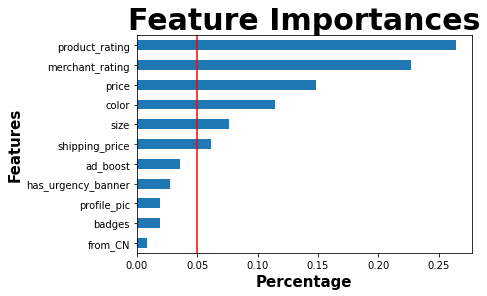

In [17]:
# Gets feature importances
importances = pd.Series(
    forest_clf.named_steps['randomforestclassifier'].feature_importances_,
    index=X_train.columns
    )
# Plots feature importances from most important to least
plt.figure(figsize=(6,4), facecolor='white')
plt.axvline(0.05,color='red')
plt.title('Feature Importances',size=30,weight='bold')
plt.ylabel('Features',size=15,weight='bold')
plt.xlabel('Percentage',size=15,weight='bold')
importances.sort_values().plot(kind='barh')
plt.show()

### <font color='hotpink' face='Comic Sans MS'> **A few observations:**

<font color='hotpink' face='Comic Sans MS'> 1) Product rating and merchant rating are way above the non-price features.  Wish is known for having very, very low prices, so customer reviews grant assurance to people who are skeptical about shopping on a website with extreme discounts.

<font color='hotpink' face='Comic Sans MS'> 2) Whether or not the seller has taken 30 seconds to upload a profile picture is more predictive than if they have any badges.  You might think that badges identifying local products, fast shipping, high product quality, etc. would be more influential, but it appears that the simple presence of the seller's profile picture is more important.  Perhaps this is a psychological thing tied in with # 1.  Actually seeing the person you're buying from might offer a sort of subconscious trust.  Might be a stretch, but I could see it...

<font color='hotpink' face='Comic Sans MS'> 3) Price and shipping price are highly predictive - no surprise there.

<font color='hotpink' face='Comic Sans MS'> 4) It seems that having an ad-booster influences sales volume, albeit slightly.  If a seller wants to sell a lot, assuming the ad-boosting price is reasonable, then they should consider invensting in ad-bosters.

<font color='hotpink' face='Comic Sans MS'> 5) Origin country didn't seem to matter.  I wonder if this is visible to the buyer at the time of purchase or if the consumer truly doesn't care how far the product must travel and, in turn, how long the item may take to arrive.

# Permutation Importance

In [18]:
# Define a function that will report permutation importances for each
perm_difs = {}
def perm_importances(X,y):
    # Iterate through every column/feature
    for col in X.columns:
        feature = col
        # Make copy
        X_val_permuted = X_val.copy()
        # Permute
        X_val_permuted[feature] = np.random.permutation(X_val[feature])
        # Assign accuracy scores to variables
        val_acc = forest_clf.score(X_val, y_val)
        perm_val_acc = forest_clf.score(X_val_permuted, y_val)
        # Print results
        print(feature.upper(),'\n')
        print('Validation Accuracy:', round(val_acc,3))
        print('Permuted Validation Accuracy:', round(perm_val_acc,3))
        print('Permuted Accuracy Difference:', round(val_acc - perm_val_acc,3),'\n\n')
        perm_difs[col] = round(val_acc - perm_val_acc,10)
    # Print out the feature and the difference its permutation made on the model in descending order
    sorted_perm_difs = {k:v for k,v in sorted(perm_difs.items(), key=lambda item: item[1], reverse=True)}
    for key,value in sorted_perm_difs.items():
        print(key,value)

In [19]:
# Get the importances
perm_importances(X_val,y_val)

PRICE 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.572
Permuted Accuracy Difference: -0.004 


AD_BOOST 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.538
Permuted Accuracy Difference: 0.03 


PRODUCT_RATING 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.504
Permuted Accuracy Difference: 0.064 


COLOR 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.572
Permuted Accuracy Difference: -0.004 


SIZE 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.538
Permuted Accuracy Difference: 0.03 


SHIPPING_PRICE 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.581
Permuted Accuracy Difference: -0.013 


HAS_URGENCY_BANNER 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.568
Permuted Accuracy Difference: 0.0 


MERCHANT_RATING 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.53
Permuted Accuracy Difference: 0.038 


PROFILE_PIC 

Validation Accuracy: 0.568
Permuted Validation Accuracy: 0.568
Pe

In [20]:
perm_difs_df = pd.DataFrame(perm_difs.keys())

In [21]:
perm_difs_df.columns = ['feature']
perm_difs_df['permutation_importance'] = perm_difs.values()

In [22]:
# Sort by permutation importance
perm_difs_df.sort_values('permutation_importance',inplace=True)
perm_difs_df.reset_index(drop=True)

,feature,permutation_importance
0,shipping_price,-0.012712
1,price,-0.004237
2,color,-0.004237
3,has_urgency_banner,0.000000
4,profile_pic,0.000000
5,from_CN,0.000000
6,badges,0.008475
7,ad_boost,0.029661
8,size,0.029661
9,merchant_rating,0.038136


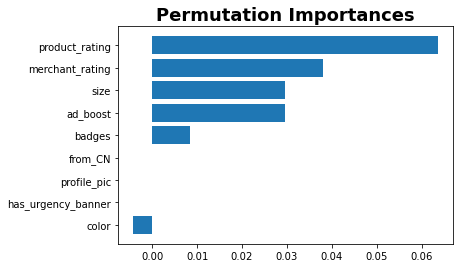

In [23]:
plt.barh(perm_difs_df.feature[-9:], perm_difs_df.permutation_importance[-9:])
plt.title('Permutation Importances',size=18,weight='bold')

plt.show()

# Gradient Boosting

In [24]:
# Adaptive

ada_clf = make_pipeline(OrdinalEncoder(),
                        AdaBoostClassifier(n_estimators = 60,
                                           learning_rate = 0.5,
                                           random_state=42)
                        )
ada_clf.fit(X_train,y_train)

print('Training Accuracy:', ada_clf.score(X_train,y_train))
print('Validation Accuracy:', ada_clf.score(X_val,y_val))

Training Accuracy: 0.5862068965517241
Validation Accuracy: 0.538135593220339


In [25]:
# Gradient

xg_clf = make_pipeline(OrdinalEncoder(),
                       XGBClassifier(n_estimators=50, learning_rate = .26, random_state=42)
                      )

xg_clf.fit(X_train,y_train)

print('Training Accuracy:', xg_clf.score(X_train,y_train))
print('Validation Accuracy: XGBoost', xg_clf.score(X_val, y_val))

Training Accuracy: 0.9682395644283122
Validation Accuracy: XGBoost 0.538135593220339


<font color='hotpink' face='Comic Sans MS'> GXBoost and AdaBoost both hurt my model, even after I played with the learning rate, n_estimators, etc.  Maybe because I have too small a dataset?

In [26]:
print('Random Forest')
print(classification_report(y_val, forest_clf.predict(X_val)))

Random Forest
              precision    recall  f1-score   support

        high       0.44      0.62      0.52        63
         low       0.73      0.65      0.69       113
      medium       0.46      0.37      0.41        60

    accuracy                           0.57       236
   macro avg       0.54      0.54      0.54       236
weighted avg       0.58      0.57      0.57       236



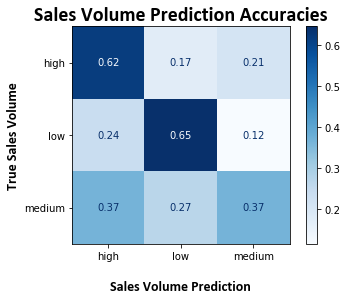

In [27]:
plot_confusion_matrix(forest_clf, X_val, y_val, cmap=plt.cm.Blues, normalize='true')
plt.title('Sales Volume Prediction Accuracies',fontname='Calibri',size=20,weight='bold')
plt.xlabel("\nSales Volume Prediction",fontname='Calibri',size=14,weight='bold')
plt.ylabel("True Sales Volume",fontname='Calibri',size=14,weight='bold')
plt.show()

In [28]:
# Make a function that will ordinally encode data in each feature matrix

def ordinal_encode(X):
    encoder = OrdinalEncoder()
    X = encoder.fit_transform(X)

In [29]:
ordinal_encode(X_train)
ordinal_encode(X_val)
ordinal_encode(X_test)

In [30]:
encoder = OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_val = encoder.fit_transform(X_val)
X_test = encoder.fit_transform(X_test)
X_train.head()

,price,ad_boost,product_rating,color,size,shipping_price,has_urgency_banner,merchant_rating,profile_pic,from_CN,badges
0,14,0,3.76,1,1,4,1.0,4.128521,0,1.0,1
1,22,1,3.45,2,2,2,1.0,3.899673,0,1.0,1
2,43,0,3.57,3,2,3,1.0,3.989831,0,1.0,1
3,8,1,4.03,4,1,2,0.0,4.020435,0,1.0,1
4,3,1,3.10,5,3,1,1.0,4.001588,0,1.0,1


In [31]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train,y_train)
print('Training Accuracy:', forest_clf.score(X_train,y_train))
print('Validation Accuracy:', forest_clf.score(X_val,y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.5932203389830508


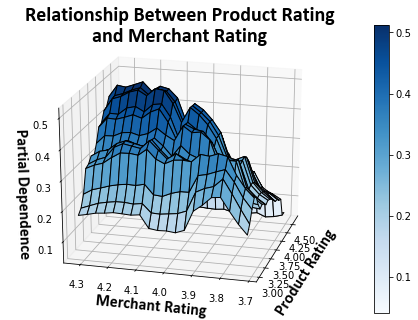

In [32]:
fig = plt.figure()

features = ('product_rating', 'merchant_rating')
pdp, axes = partial_dependence(forest_clf, X_train, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.Blues, edgecolor='k')
ax.set_xlabel('Product Rating',fontname='Calibri',size=16,weight='bold')
ax.set_ylabel('Merchant Rating',fontname='Calibri',size=16,weight='bold')
ax.set_zlabel('Partial Dependence',fontname='Calibri',size=16,weight='bold', rotation=90)
#  Best angle
ax.view_init(elev=22, azim=195)
plt.colorbar(surf)
plt.title('Relationship Between Product Rating\nand Merchant Rating',
         fontname='Calibri',size=20,weight='bold')
plt.subplots_adjust(top=0.9)

plt.show()